In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, Matern, RationalQuadratic, ExpSineSquared
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
import random
import re
import itertools
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [4]:
df = pd.read_csv('8-11-23_cleaned_enthalpy_data.csv')
fp_columns = ['1/length']
for col in df.columns:
    if 'fp_' in col:
        fp_columns.append(col)

# Plotting Functions

In [180]:
def LOOCV_parity_plot(data, stds=False, ax=False):
    if not stds:
        stds = [0 for x in range(data.shape[0])]
    # fig = plt.figure(figsize = (8,8))
    min_x = data[:,0].min()
    max_x = data[:,0].max()
    min_y = data[:,1].min()
    max_y = data[:,1].max()
    bounds = (min(min_x - 2, min_y  - 2), max(max_x + 2, max_y + 2))

    if not ax:
        ax = plt.gca()
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)

    # ax.set_aspect("equal", adjustable = "box")
    plots_ = list()
   
    ax.errorbar(data[:,0].flatten(), data[:,1].flatten(), 
                              yerr=np.array(stds).flatten(), c='blue', zorder=4, ecolor='lightgrey', fmt='o')
    # plots_.append(plot_)

    ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)

    # labeling axes
    # plt.title(title, fontsize=15, weight='bold')
    # plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
    # plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

    ## CALCULATE STATISTICS
    rmse = np.sqrt(mean_squared_error(data[:,0], data[:,1]))
    mae = mean_absolute_error(data[:,0], data[:,1])
    r2 = r2_score(data[:,0], data[:,1])
    text = f" RMSE = {rmse:0.1f} kJ/mol\n MAE = {mae:0.1f} kJ/mol\n $R^{2}$ = {r2:0.2f}"
    # ax.gca().text(0.05, 0.95, text_case_1,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.92, text,transform=ax.transAxes, fontsize=16, verticalalignment='top',) # weight="bold")
    return ax

def correlation_plot(x_data, y_data, ax):
    # fig = plt.figure(figsize = (8,8))
    min_x = min(x_data)
    max_x = max(x_data)
    min_y = min(y_data)
    max_y = max(y_data)
    bounds = (min(min_x - 2, min_y  - 2), max(max_x + 2, max_y + 2))

    # ax = plt.gca()
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)

    # ax.set_aspect("equal", adjustable = "box")
    plots_ = list()
   
    ax.errorbar(x_data, y_data, c='blue', zorder=4, ecolor='lightgrey', fmt='o')
    # plots_.append(plot_)

    ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)

    # labeling axes
    # plt.title(title, fontsize=15, weight='bold')
    # plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
    # plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

    ## CALCULATE STATISTICS
    r, _ = pearsonr(x_data,y_data)
    text = f"r = {r:0.3f}"
    # ax3.text(0.05, 0.95, text,transform=ax3.transAxes, fontsize=15, verticalalignment='top')
    # ax.gca().text(0.05, 0.95, text_case_1,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.03, 0.92, text,transform=ax.transAxes, fontsize=18, verticalalignment='top')
    return ax

In [6]:
print(df.columns.tolist())

['Unnamed: 0', '1/length', 'ID', 'roe_kj/mol', 'smiles_monomer', 'smiles_polymer', 'source', 'afp_Br1_C4_C3', 'afp_Br1_C4_C4', 'afp_C3_C3_C3', 'afp_C3_C3_C4', 'afp_C3_C3_H1', 'afp_C3_C3_N3', 'afp_C3_C3_O1', 'afp_C3_C3_O2', 'afp_C3_C3_S2', 'afp_C3_C4_C3', 'afp_C3_C4_C4', 'afp_C3_C4_H1', 'afp_C3_C4_N3', 'afp_C3_C4_O2', 'afp_C3_C4_S2', 'afp_C3_N3_C3', 'afp_C3_N3_C4', 'afp_C3_N3_H1', 'afp_C3_N3_O1', 'afp_C3_O2_C4', 'afp_C3_O2_H1', 'afp_C3_S2_C3', 'afp_C3_S2_C4', 'afp_C4_C3_C4', 'afp_C4_C3_H1', 'afp_C4_C3_N3', 'afp_C4_C3_O1', 'afp_C4_C3_O2', 'afp_C4_C3_S1', 'afp_C4_C3_S2', 'afp_C4_C4_C4', 'afp_C4_C4_H1', 'afp_C4_C4_N3', 'afp_C4_C4_O2', 'afp_C4_C4_S2', 'afp_C4_C4_S3', 'afp_C4_C4_S4', 'afp_C4_C4_Si4', 'afp_C4_N3_C4', 'afp_C4_N3_H1', 'afp_C4_N3_Si4', 'afp_C4_O2_C4', 'afp_C4_O2_H1', 'afp_C4_O2_P4', 'afp_C4_O2_Si4', 'afp_C4_S2_C4', 'afp_C4_S2_S2', 'afp_C4_S3_C4', 'afp_C4_S4_O1', 'afp_C4_Si4_C4', 'afp_C4_Si4_N3', 'afp_C4_Si4_O2', 'afp_H1_C3_H1', 'afp_H1_C3_O2', 'afp_H1_C4_H1', 'afp_H1_C4_N3', 'af

# Random Forest

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


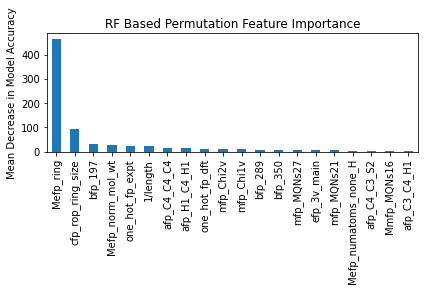

In [9]:
# using random forest with permutation feature importance now
x_for_fe = df[fp_columns].to_numpy()
y_for_fe = df['roe_kj/mol'].to_numpy()
cv = KFold(n_splits=5)

grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 10] ,
    'min_samples_leaf': [1, 3, 5, 10, 20, 50],
    'min_impurity_decrease': [0.01, 0.02],
    'max_features': ['sqrt', 'log2', 0.9]
}
model = RandomForestRegressor()

# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
results = search.fit(x_for_fe, y_for_fe)
model = results.best_estimator_

# using permutation feature importance to see top 20 features
r = permutation_importance(model, x_for_fe, y_for_fe, n_repeats=10, scoring='neg_mean_squared_error')
important_count=0
importances = []
feature_names = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        importances.append(r.importances_mean[i])
        feature_names.append(fp_columns[i])
        important_count += 1
#         if important_count == 80:
#             break
rf_importances_to_plot = pd.Series(importances[:20], index=feature_names[:20])  # only going to plot first 20
rf_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
rf_importances_to_plot.plot.bar(ax=ax)
ax.set_title("RF Based Permutation Feature Importance")
ax.set_ylabel("Mean Decrease in Model Accuracy")
fig.tight_layout()
plt.show()

In [10]:
print(results.best_params_)
rf_params = results.best_params_
fp_columns_fe = feature_names[:50]
print(fp_columns_fe)
print(len(fp_columns_fe), len(feature_names))

{'max_depth': 10, 'max_features': 0.9, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'n_estimators': 10}
['Mefp_ring', 'cfp_rop_ring_size', 'bfp_197', 'Mefp_norm_mol_wt', 'one_hot_fp_expt', '1/length', 'afp_C4_C4_C4', 'afp_H1_C4_H1', 'one_hot_fp_dft', 'mfp_Chi2v', 'mfp_Chi1v', 'bfp_289', 'bfp_350', 'mfp_MQNs27', 'efp_3v_main', 'mfp_MQNs21', 'Mefp_numatoms_none_H', 'afp_C4_C3_S2', 'Mmfp_MQNs16', 'afp_C3_C4_H1', 'Mmfp_Chi2n', 'Mmfp_MQNs31', 'Mmfp_MQNs20', 'Mmfp_MQNs36', 'bfp_267', 'efp_main_chain_rel', 'Mmfp_Chi1v', 'mfp_Chi0v', 'Mmfp_MQNs13', 'efp_4v_main', 'bfp_315', 'mfp_tpsa', 'bfp_305', 'Mmfp_Chi2v', 'Mmfp_MQNs32', 'Mmfp_MQNs19', 'bfp_364', 'Mmfp_Chi1n', 'Mmfp_Chi0v', 'afp_H1_C4_O2', 'afp_C3_C4_C4', 'afp_O1_C3_O2', 'efp_norm_mol_wt', 'bfp_304', 'bfp_282', 'Mmfp_HallKierAlpha', 'afp_C3_O2_C4', 'afp_C4_C4_S2', 'mfp_MQNs28', 'Mafp_C4']
50 102


In [13]:
# separating into exp and dft dfs to make custom LOOCV easier
df_exp = df[df['source']=='expt']
print(df_exp.shape)
df_dft = df[df['source']=='dft']
print(df_dft.shape)
exp_IDs_for_cases = set(df_exp['ID']).intersection(set(df_dft['ID']))

(109, 260)
(350, 260)


In [18]:
# Case 0 loocv, custom cv (no supporting DFT used, single-task)
errors_case_0_custom_cv_rf = []
sigmas_case_0_custom_cv_rf = []
predictions_case_0_custom_cv_rf = []
for id_to_remove in exp_IDs_for_cases:
    # print(id_to_remove)
    indices_to_remove = df_exp[df_exp['ID']==id_to_remove].index.tolist()
    train_df = df_exp.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    # print(roe_exp_scaler.inverse_transform(train_df['roe_normalized'].to_numpy().reshape(1,-1)))
    # print(train_df['roe_kj/mol'].to_numpy())
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = RandomForestRegressor(**rf_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_0_custom_cv_rf.append(error)
    predictions_case_0_custom_cv_rf.append([y_test, prediction])
print(np.mean(errors_case_0_custom_cv_rf))
predictions_case_0_custom_cv_rf = np.array(predictions_case_0_custom_cv_rf)

6.049495194390971


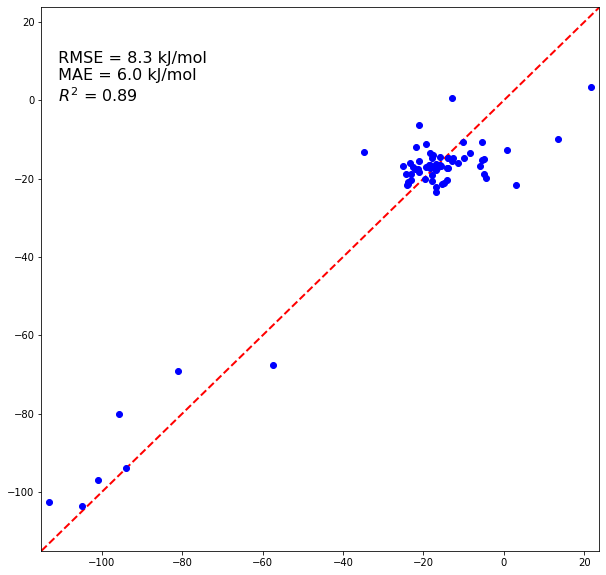

In [23]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_0_custom_cv_rf, sigmas_case_0_custom_cv_rf, ax)
fig.show()

In [25]:
# Case 1 loocv, custom cv (dft for non-held out cases)
errors_case_1_custom_cv_rf = []
sigmas_case_1_custom_cv_rf = []
predictions_case_1_custom_cv_rf = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[df['ID']==id_to_remove].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = RandomForestRegressor(**rf_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_1_custom_cv_rf.append(error)
    predictions_case_1_custom_cv_rf.append([y_test, prediction])
print(np.mean(errors_case_1_custom_cv_rf))
predictions_case_1_custom_cv_rf = np.array(predictions_case_1_custom_cv_rf)

7.182048203916326


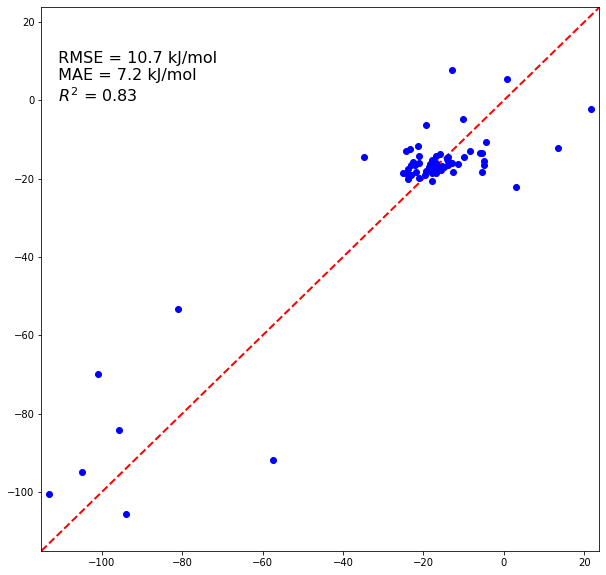

In [26]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_1_custom_cv_rf, ax=ax)
fig.show()

In [28]:
# Case 2 loocv, custom cv (case 1 + loopsize 3 for hold-out)
errors_case_2_custom_cv_rf = []
sigmas_case_2_custom_cv_rf = []
predictions_case_2_custom_cv_rf = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['1/length_non_normalized']!=0.333)].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = RandomForestRegressor(**rf_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_2_custom_cv_rf.append(error)
    predictions_case_2_custom_cv_rf.append([y_test, prediction])
print(np.mean(errors_case_2_custom_cv_rf))
predictions_case_2_custom_cv_rf = np.array(predictions_case_2_custom_cv_rf)

7.020564824472875


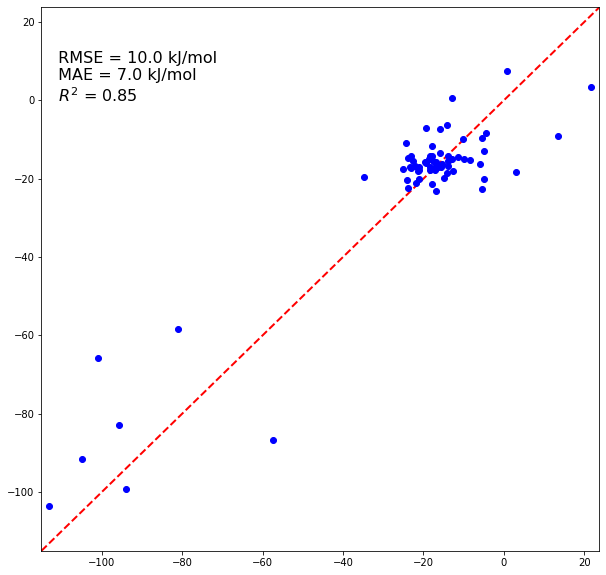

In [29]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_2_custom_cv_rf, ax=ax)
fig.show()

In [32]:
# Case 3 loocv, custom cv (case 2 + all dft data for hold-out)
errors_case_3_custom_cv_rf = []
sigmas_case_3_custom_cv_rf = []
predictions_case_3_custom_cv_rf = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['source']=='expt')].index.tolist()
    # print(indices_to_remove)
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = RandomForestRegressor(**rf_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_3_custom_cv_rf.append(error)
    predictions_case_3_custom_cv_rf.append([y_test, prediction])
print(np.mean(errors_case_3_custom_cv_rf))
predictions_case_3_custom_cv_rf = np.array(predictions_case_3_custom_cv_rf)

6.289907359032662


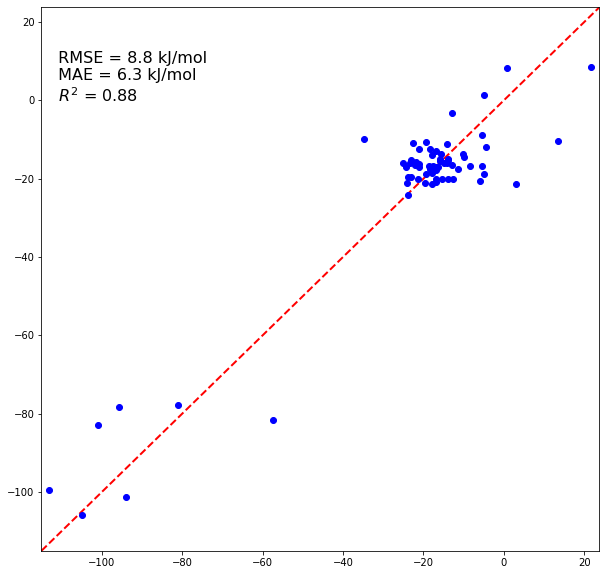

In [33]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_3_custom_cv_rf, ax=ax)
fig.show()

# SVR

Fitting 5 folds for each of 35 candidates, totalling 175 fits


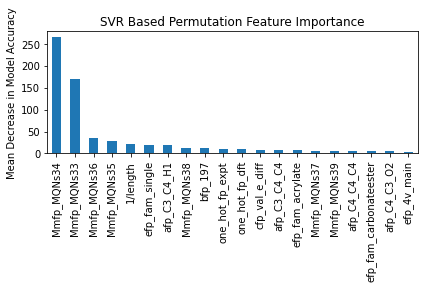

In [37]:
# using SVR with permutation feature importance now
x_for_fe = df[fp_columns].to_numpy()
y_for_fe = df['roe_kj/mol'].to_numpy()
cv = KFold(n_splits=5)

grid = {
    'C': [0.1, 0.25, 0.5, 1, 5, 50 ,100], 'gamma': [x/100 for x in range(0,25,5)]
}
model = SVR()

# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
results = search.fit(x_for_fe, y_for_fe)
model = results.best_estimator_

# using permutation feature importance to see top 20 features
r = permutation_importance(model, x_for_fe, y_for_fe, n_repeats=10, scoring='neg_mean_squared_error')
important_count=0
importances = []
feature_names = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        importances.append(r.importances_mean[i])
        feature_names.append(fp_columns[i])
        important_count += 1
        # if important_count == 80:
            # break
svr_importances_to_plot = pd.Series(importances[:20], index=feature_names[:20])  # only going to plot first 20
svr_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
svr_importances_to_plot.plot.bar(ax=ax)
ax.set_title("SVR Based Permutation Feature Importance")
ax.set_ylabel("Mean Decrease in Model Accuracy")
fig.tight_layout()
plt.show()

In [38]:
print(results.best_params_)
svr_params = results.best_params_
fp_columns_fe = feature_names[:50]
print(fp_columns_fe)
print(len(fp_columns_fe), len(feature_names))

{'C': 100, 'gamma': 0.1}
['Mmfp_MQNs34', 'Mmfp_MQNs33', 'Mmfp_MQNs36', 'Mmfp_MQNs35', '1/length', 'efp_fam_single', 'afp_C3_C4_H1', 'Mmfp_MQNs38', 'bfp_197', 'one_hot_fp_expt', 'one_hot_fp_dft', 'cfp_val_e_diff', 'afp_C3_C4_C4', 'efp_fam_acrylate', 'Mmfp_MQNs37', 'Mmfp_MQNs39', 'afp_C4_C4_C4', 'efp_fam_carbonateester', 'afp_C4_C3_O2', 'efp_4v_main', 'bfp_249', 'bfp_361', 'afp_C3_C4_C3', 'Mafp_N3', 'cfp_rop_ring_size', 'bfp_376', 'Mafp_S1', 'efp_side_chain_abs', 'afp_C4_C3_S2', 'bfp_375', 'efp_fam_polyamides', 'afp_C4_S2_C4', 'bfp_289', 'Mmfp_MQNs32', 'afp_C3_C4_S2', 'bfp_305', 'efp_3v_main', 'bfp_267', 'afp_C3_C3_C4', 'afp_C4_C3_H1', 'afp_C3_S2_C4', 'Mmfp_Chi0n', 'bfp_304', 'Mmfp_Chi1n', 'afp_C4_C4_H1', 'bfp_363', 'Mmfp_MQNs29', 'bfp_342', 'mfp_MQNs26', 'Mafp_H1']
50 148


In [39]:
# Case 0 loocv, custom cv (no supporting DFT used, single-task)
errors_case_0_custom_cv_svr = []
sigmas_case_0_custom_cv_svr = []
predictions_case_0_custom_cv_svr = []
for id_to_remove in exp_IDs_for_cases:
    # print(id_to_remove)
    indices_to_remove = df_exp[df_exp['ID']==id_to_remove].index.tolist()
    train_df = df_exp.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    # print(roe_exp_scaler.inverse_transform(train_df['roe_normalized'].to_numpy().reshape(1,-1)))
    # print(train_df['roe_kj/mol'].to_numpy())
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = SVR(**svr_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_0_custom_cv_svr.append(error)
    predictions_case_0_custom_cv_svr.append([y_test, prediction])
print(np.mean(errors_case_0_custom_cv_svr))
predictions_case_0_custom_cv_svr = np.array(predictions_case_0_custom_cv_svr)

9.788457632895579


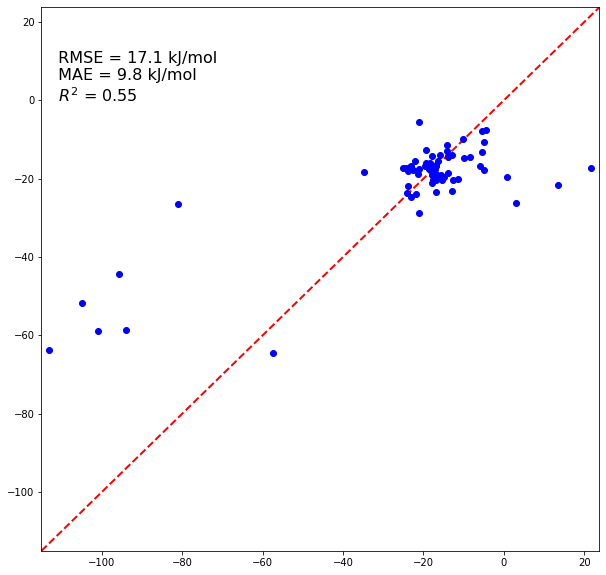

In [42]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_0_custom_cv_svr, ax=ax)
fig.show()

In [46]:
# Case 1 loocv, custom cv (dft for non-held out cases)
errors_case_1_custom_cv_svr = []
sigmas_case_1_custom_cv_svr = []
predictions_case_1_custom_cv_svr = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[df['ID']==id_to_remove].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = SVR(**svr_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_1_custom_cv_svr.append(error)
    predictions_case_1_custom_cv_svr.append([y_test, prediction])
print(np.mean(errors_case_1_custom_cv_svr))
predictions_case_1_custom_cv_svr = np.array(predictions_case_1_custom_cv_svr)

7.782791360719356


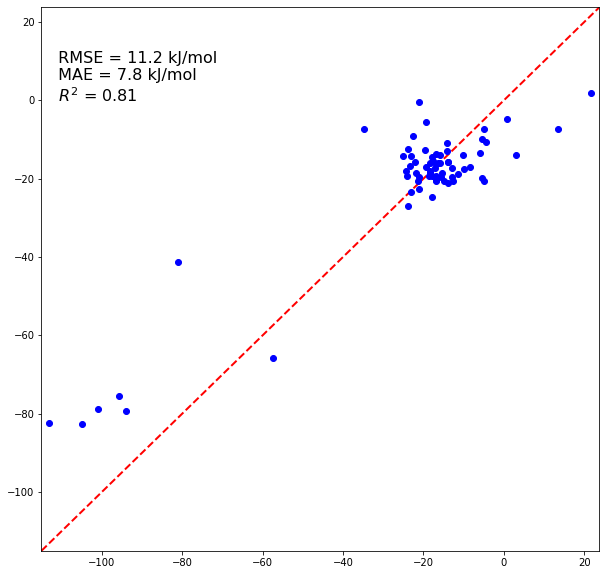

In [47]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_1_custom_cv_svr, ax=ax)
fig.show()

In [43]:
# Case 2 loocv, custom cv (case 1 + loopsize 3 for hold-out)
errors_case_2_custom_cv_svr = []
sigmas_case_2_custom_cv_svr = []
predictions_case_2_custom_cv_svr = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['1/length_non_normalized']!=0.333)].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = SVR(**svr_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_2_custom_cv_svr.append(error)
    predictions_case_2_custom_cv_svr.append([y_test, prediction])
print(np.mean(errors_case_2_custom_cv_svr))
predictions_case_2_custom_cv_svr = np.array(predictions_case_2_custom_cv_svr)

7.509883427240709


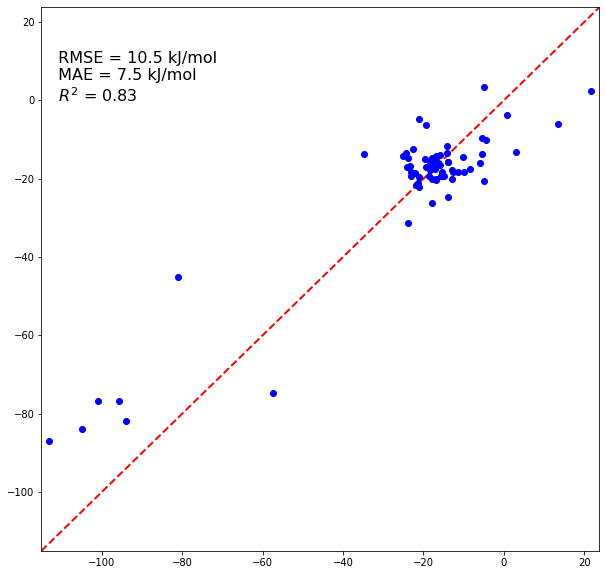

In [45]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_2_custom_cv_svr, ax=ax)
fig.show()

In [48]:
# Case 3 loocv, custom cv (case 2 + all dft data for hold-out)
errors_case_3_custom_cv_svr = []
sigmas_case_3_custom_cv_svr = []
predictions_case_3_custom_cv_svr = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['source']=='expt')].index.tolist()
    # print(indices_to_remove)
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = SVR(**svr_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_3_custom_cv_svr.append(error)
    predictions_case_3_custom_cv_svr.append([y_test, prediction])
print(np.mean(errors_case_3_custom_cv_svr))
predictions_case_3_custom_cv_svr = np.array(predictions_case_3_custom_cv_svr)

7.034219395434248


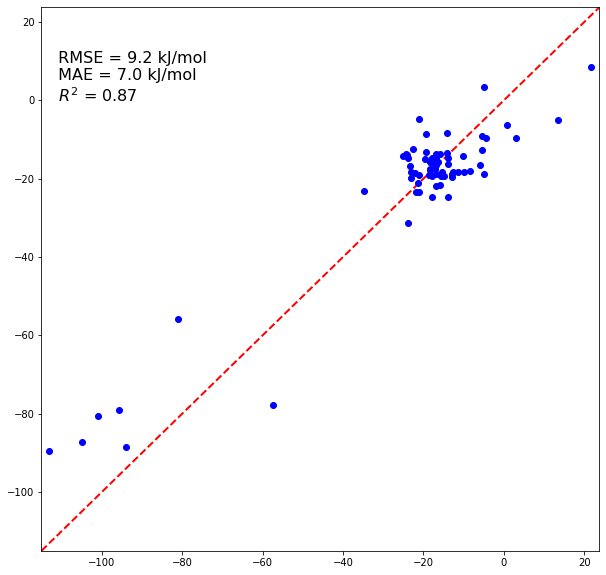

In [49]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_3_custom_cv_svr, ax=ax)
fig.show()

# Boosted Forest

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


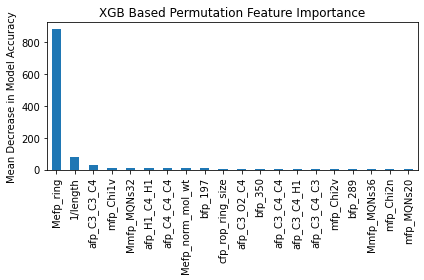

In [52]:
# using xgb with permutation feature importance now
x_for_fe = df[fp_columns].to_numpy()
y_for_fe = df['roe_kj/mol'].to_numpy()
cv = KFold(n_splits=5)

grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 6], 
    # 'subsample': [0.75, 1.0], 
    # 'colsample_bytree': [0.75, 1.0], 
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200]
}
# grid from sklearn rf
# grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [3, 5, 10] ,
#     'min_samples_leaf': [1, 3, 5, 10, 20, 50],
#     'min_impurity_decrease': [0.01, 0.02],
#     'max_features': ['sqrt', 'log2', 0.9]
# }
model = xgb.XGBRegressor(eval_metric='rmsle')

# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
results = search.fit(x_for_fe, y_for_fe)
model = results.best_estimator_

# using permutation feature importance to see top 20 features
r = permutation_importance(model, x_for_fe, y_for_fe, n_repeats=10, scoring='neg_mean_squared_error')
important_count=0
importances = []
feature_names = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        importances.append(r.importances_mean[i])
        feature_names.append(fp_columns[i])
        important_count += 1
        # if important_count == 80:
            # break
xgb_importances_to_plot = pd.Series(importances[:20], index=feature_names[:20])  # only going to plot first 20
xgb_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
xgb_importances_to_plot.plot.bar(ax=ax)
ax.set_title("XGB Based Permutation Feature Importance")
ax.set_ylabel("Mean Decrease in Model Accuracy")
fig.tight_layout()
plt.show()

In [53]:
print(results.best_params_)
xgb_params = results.best_params_
fp_columns_fe = feature_names[:50]
print(fp_columns_fe)
print(len(fp_columns_fe), len(feature_names))

{'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
['Mefp_ring', '1/length', 'afp_C3_C3_C4', 'mfp_Chi1v', 'Mmfp_MQNs32', 'afp_H1_C4_H1', 'afp_C4_C4_C4', 'Mefp_norm_mol_wt', 'bfp_197', 'cfp_rop_ring_size', 'afp_C3_O2_C4', 'bfp_350', 'afp_C3_C4_C4', 'afp_C3_C4_H1', 'afp_C3_C4_C3', 'mfp_Chi2v', 'bfp_289', 'Mmfp_MQNs36', 'mfp_Chi2n', 'mfp_MQNs20', 'Mmfp_Chi2n', 'afp_H1_C3_H1', 'mfp_MQNs16', 'bfp_359', 'afp_C4_C3_S2', 'efp_3v_main', 'mfp_Chi1n', 'efp_main_chain_rel', 'bfp_364', 'Mafp_O2', 'afp_C4_C4_H1', 'bfp_222', 'bfp_282', 'afp_C4_C3_O1', 'afp_C4_C3_O2', 'afp_C3_C4_O2', 'mfp_MQNs21', 'afp_C4_S2_C4', 'afp_H1_C4_O2', 'bfp_304', 'Mmfp_Chi2v', 'afp_C4_C4_S2', 'afp_C4_N3_H1', 'Mmfp_Chi0v', 'mfp_MQNs13', 'Mafp_H1', 'afp_C4_C4_S3', 'afp_S1_C3_S2', 'bfp_215', 'afp_C4_O2_C4']
50 107


In [54]:
# Case 0 loocv, custom cv (no supporting DFT used, single-task)
errors_case_0_custom_cv_xgb = []
sigmas_case_0_custom_cv_xgb = []
predictions_case_0_custom_cv_xgb = []
for id_to_remove in exp_IDs_for_cases:
    # print(id_to_remove)
    indices_to_remove = df_exp[df_exp['ID']==id_to_remove].index.tolist()
    train_df = df_exp.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    # print(roe_exp_scaler.inverse_transform(train_df['roe_normalized'].to_numpy().reshape(1,-1)))
    # print(train_df['roe_kj/mol'].to_numpy())
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_0_custom_cv_xgb.append(error)
    predictions_case_0_custom_cv_xgb.append([y_test, prediction])
print(np.mean(errors_case_0_custom_cv_xgb))
predictions_case_0_custom_cv_xgb = np.array(predictions_case_0_custom_cv_xgb)

6.229235736555391


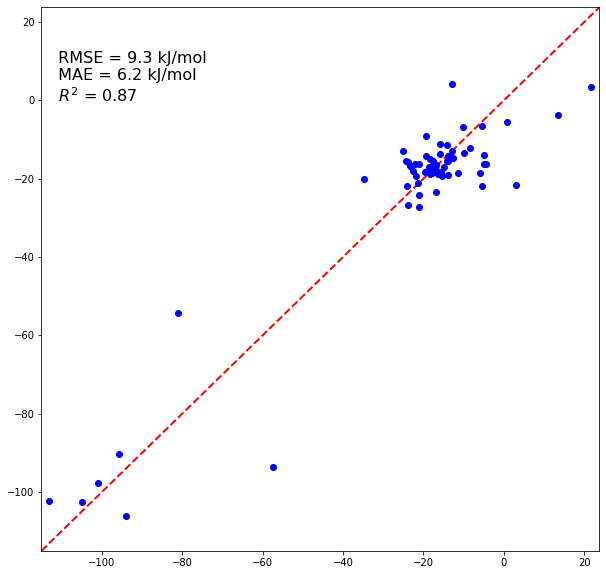

In [56]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_0_custom_cv_xgb, ax=ax)
fig.show()

In [57]:
# Case 1 loocv, custom cv (dft for non-held out cases)
errors_case_1_custom_cv_xgb = []
sigmas_case_1_custom_cv_xgb = []
predictions_case_1_custom_cv_xgb = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[df['ID']==id_to_remove].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_1_custom_cv_xgb.append(error)
    predictions_case_1_custom_cv_xgb.append([y_test, prediction])
print(np.mean(errors_case_1_custom_cv_xgb))
predictions_case_1_custom_cv_xgb = np.array(predictions_case_1_custom_cv_xgb)

6.534342285154158


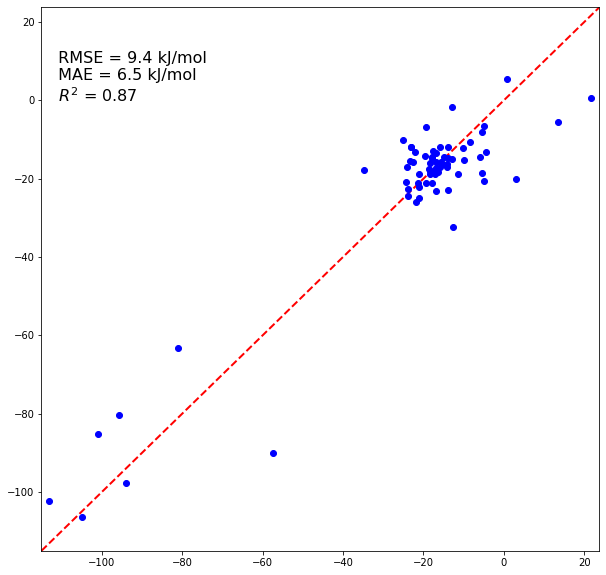

In [58]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_1_custom_cv_xgb, ax=ax)
fig.show()

In [59]:
# Case 2 loocv, custom cv (case 1 + loopsize 3 for hold-out)
errors_case_2_custom_cv_xgb = []
sigmas_case_2_custom_cv_xgb = []
predictions_case_2_custom_cv_xgb = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['1/length_non_normalized']!=0.333)].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_2_custom_cv_xgb.append(error)
    predictions_case_2_custom_cv_xgb.append([y_test, prediction])
print(np.mean(errors_case_2_custom_cv_xgb))
predictions_case_2_custom_cv_xgb = np.array(predictions_case_2_custom_cv_xgb)

7.230025670246573


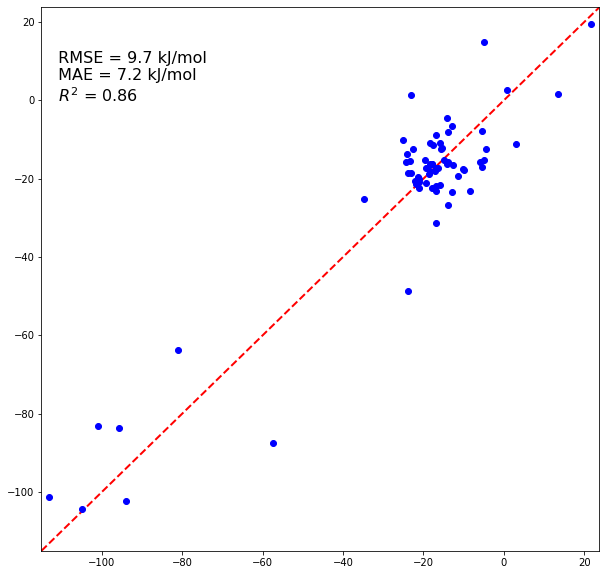

In [60]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_2_custom_cv_xgb, ax=ax)
fig.show()

In [61]:
# Case 3 loocv, custom cv (case 2 + all dft data for hold-out)
errors_case_3_custom_cv_xgb = []
sigmas_case_3_custom_cv_xgb = []
predictions_case_3_custom_cv_xgb = []
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['source']=='expt')].index.tolist()
    # print(indices_to_remove)
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_3_custom_cv_xgb.append(error)
    predictions_case_3_custom_cv_xgb.append([y_test, prediction])
print(np.mean(errors_case_3_custom_cv_xgb))
predictions_case_3_custom_cv_xgb = np.array(predictions_case_3_custom_cv_xgb)

6.834096662963896


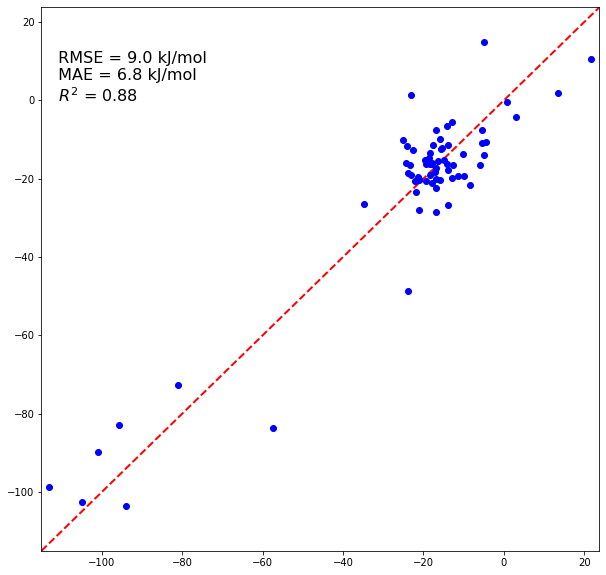

In [62]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_3_custom_cv_xgb, ax=ax)
fig.show()

# GPR

Fitting 5 folds for each of 12 candidates, totalling 60 fits


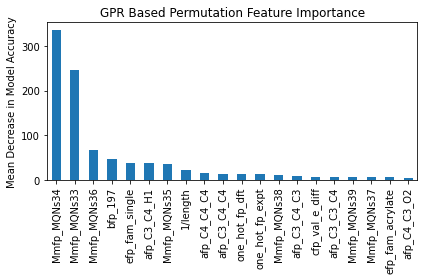

In [63]:
# using GPR with permutation feature importance now
x_for_fe = df[fp_columns].to_numpy()
y_for_fe = df['roe_kj/mol'].to_numpy()
cv = KFold(n_splits=5)
y_average = np.average(y_for_fe)
noise_estimate = np.std(y_for_fe)/3
kernel_noise = WhiteKernel(noise_level=(noise_estimate)*2, noise_level_bounds=((noise_estimate/4)**2, (noise_estimate*11)**2))
# define grid
grid = dict()
grid['kernel'] = [y_average**2*RationalQuadratic(length_scale=1)+kernel_noise, 
                  y_average**2*RBF(length_scale=1)+kernel_noise, 
                  y_average**2*Matern(length_scale=1)+kernel_noise]  # treating kernels as a hyperparameter
grid['alpha'] = [1e-10, 1e-5, 1e-2, 1e-1]  # this alpha parameter helps with fitting noise
model = GaussianProcessRegressor()

# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
results = search.fit(x_for_fe, y_for_fe)
model = results.best_estimator_

# using permutation feature importance to see top 20 features
r = permutation_importance(model, x_for_fe, y_for_fe, n_repeats=10, scoring='neg_mean_squared_error')
important_count=0
importances = []
feature_names = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        importances.append(r.importances_mean[i])
        feature_names.append(fp_columns[i])
        important_count += 1
        
gpr_importances_to_plot = pd.Series(importances[:20], index=feature_names[:20])  # only going to plot first 20
gpr_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
gpr_importances_to_plot.plot.bar(ax=ax)
ax.set_title("GPR Based Permutation Feature Importance")
ax.set_ylabel("Mean Decrease in Model Accuracy")
fig.tight_layout()
plt.show()

In [64]:
print(results.best_params_)
gpr_params = results.best_params_
fp_columns_fe = feature_names[:50]
print(fp_columns_fe)
print(len(fp_columns_fe), len(feature_names))

{'alpha': 0.01, 'kernel': 13.9**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=17.6)}
['Mmfp_MQNs34', 'Mmfp_MQNs33', 'Mmfp_MQNs36', 'bfp_197', 'efp_fam_single', 'afp_C3_C4_H1', 'Mmfp_MQNs35', '1/length', 'afp_C4_C4_C4', 'afp_C3_C4_C4', 'one_hot_fp_dft', 'one_hot_fp_expt', 'Mmfp_MQNs38', 'afp_C3_C4_C3', 'cfp_val_e_diff', 'afp_C3_C3_C4', 'Mmfp_MQNs39', 'Mmfp_MQNs37', 'efp_fam_acrylate', 'afp_C4_C3_O2', 'bfp_376', 'efp_side_chain_abs', 'afp_C4_C4_O2', 'bfp_249', 'bfp_282', 'efp_3v_main', 'afp_C4_S2_C4', 'cfp_rop_ring_size', 'afp_H1_C4_S2', 'efp_4v_side', 'afp_C4_C4_S2', 'bfp_375', 'efp_fam_polyamides', 'efp_fam_carbonateester', 'mfp_MQNs34', 'bfp_285', 'Mmfp_MQNs32', 'mfp_MQNs26', 'mfp_MQNs14', 'afp_C4_C3_S2', 'efp_4v_main', 'bfp_363', 'Mafp_N3', 'bfp_315', 'Mafp_S1', 'Mmfp_Chi0n', 'bfp_208', 'Mmfp_MQNs29', 'Mafp_H1', 'Mmfp_Chi1n']
50 206


In [172]:
# Case 0 loocv, custom cv (no supporting DFT used, single-task)
errors_case_0_custom_cv = []
sigmas_case_0_custom_cv = []
predictions_case_0_custom_cv = []
first=True
for id_to_remove in exp_IDs_for_cases:
    # print(id_to_remove)
    indices_to_remove = df_exp[df_exp['ID']==id_to_remove].index.tolist()
    train_df = df_exp.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    # print(roe_exp_scaler.inverse_transform(train_df['roe_normalized'].to_numpy().reshape(1,-1)))
    # print(train_df['roe_kj/mol'].to_numpy())
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = GaussianProcessRegressor(**gpr_params)
    model.fit(x_train,y_train)
    prediction, sigma = model.predict(x_test, return_std=True)
    # prediction = roe_exp_scaler.inverse_transform(prediction.reshape(-1, 1))
    # sigma = roe_exp_scaler.inverse_transform(sigma.reshape(-1,1))
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_0_custom_cv.append(error)
    sigmas_case_0_custom_cv.append(sigma)
    predictions_case_0_custom_cv.append([y_test, prediction])
    # doing train metrics too for LOOCV
    predictions_train = model.predict(x_train, return_std=False)
    if first:
        predictions_case_0_custom_cv_train = np.stack([y_train, predictions_train],axis=1)
        first=False
    else:
        to_add = np.stack([y_train, predictions_train],axis=1)
        predictions_case_0_custom_cv_train = np.concatenate([predictions_case_0_custom_cv_train, to_add], axis=0)
print(np.mean(errors_case_0_custom_cv))
predictions_case_0_custom_cv = np.array(predictions_case_0_custom_cv)

6.474775412660939


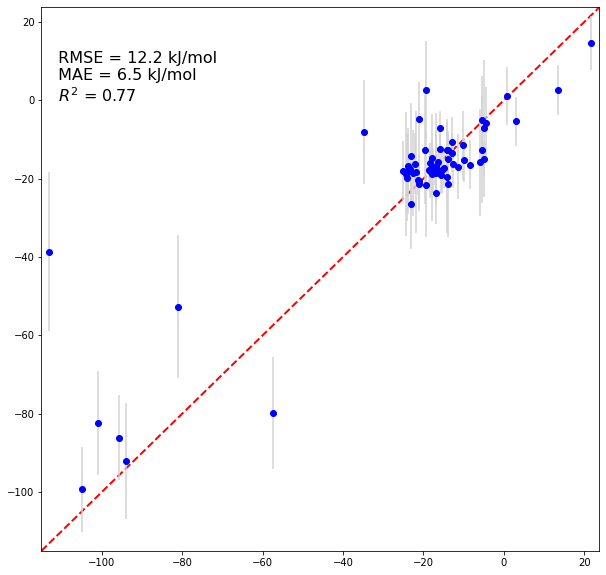

In [173]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_0_custom_cv, sigmas_case_0_custom_cv, ax)
fig.show()

In [174]:
# Case 1 loocv, custom cv (dft for non-held out cases)
errors_case_1_custom_cv = []
sigmas_case_1_custom_cv = []
predictions_case_1_custom_cv = []
first=True
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[df['ID']==id_to_remove].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = GaussianProcessRegressor(**gpr_params)
    model.fit(x_train,y_train)
    prediction, sigma = model.predict(x_test, return_std=True)
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_1_custom_cv.append(error)
    sigmas_case_1_custom_cv.append(sigma)
    predictions_case_1_custom_cv.append([y_test, prediction])
    # doing train metrics too for LOOCV
    predictions_train = model.predict(x_train, return_std=False)
    if first:
        predictions_case_1_custom_cv_train = np.stack([y_train, predictions_train],axis=1)
        first=False
    else:
        to_add = np.stack([y_train, predictions_train],axis=1)
        predictions_case_1_custom_cv_train = np.concatenate([predictions_case_1_custom_cv_train, to_add], axis=0)
print(np.mean(errors_case_1_custom_cv))
predictions_case_1_custom_cv = np.array(predictions_case_1_custom_cv)

6.455878536417863


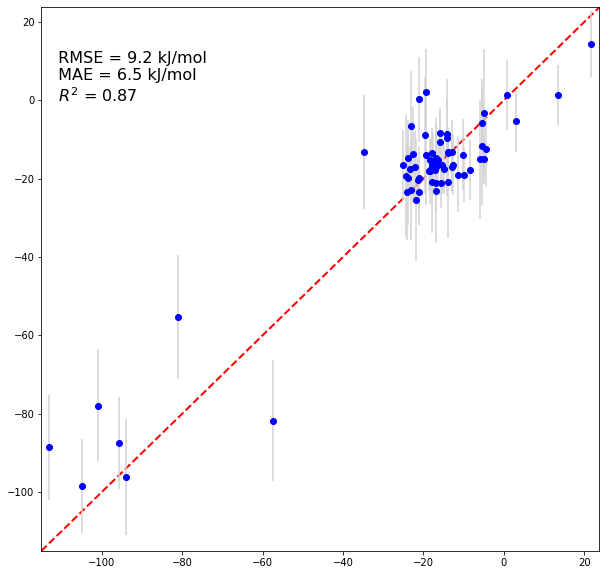

In [175]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
LOOCV_parity_plot(predictions_case_1_custom_cv, sigmas_case_1_custom_cv, ax)
# fig = LOOCV_parity_plot(predictions_case_1_custom_cv, sigmas_case_1_custom_cv, 'LOOCV Parity Plot Case 1 Custom CV')
fig.show()

In [176]:
# Case 2 loocv, custom cv (case 1 + loopsize 3 for hold-out)
errors_case_2_custom_cv = []
sigmas_case_2_custom_cv = []
predictions_case_2_custom_cv = []
first=True
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['1/length_non_normalized']!=0.333)].index.tolist()
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = GaussianProcessRegressor(**gpr_params)
    model.fit(x_train,y_train)
    prediction, sigma = model.predict(x_test, return_std=True)
    error = abs(y_test-prediction)
    if error > 10:
        print('bad id: ', id_to_remove)
    errors_case_2_custom_cv.append(error)
    sigmas_case_2_custom_cv.append(sigma)
    predictions_case_2_custom_cv.append([y_test, prediction])
    # doing train metrics too for LOOCV
    predictions_train = model.predict(x_train, return_std=False)
    if first:
        predictions_case_2_custom_cv_train = np.stack([y_train, predictions_train],axis=1)
        first=False
    else:
        to_add = np.stack([y_train, predictions_train],axis=1)
        predictions_case_2_custom_cv_train = np.concatenate([predictions_case_2_custom_cv_train, to_add], axis=0)
print(np.mean(errors_case_2_custom_cv))
predictions_case_2_custom_cv = np.array(predictions_case_2_custom_cv)

bad id:  1034.0
bad id:  1037.0
bad id:  1038.0
bad id:  17.0
bad id:  19.0
bad id:  1043.0
bad id:  1048.0
bad id:  1060.0
bad id:  1068.0
bad id:  49.0
bad id:  52.0
bad id:  981.0
bad id:  1121.0
bad id:  995.0
6.382598032572583


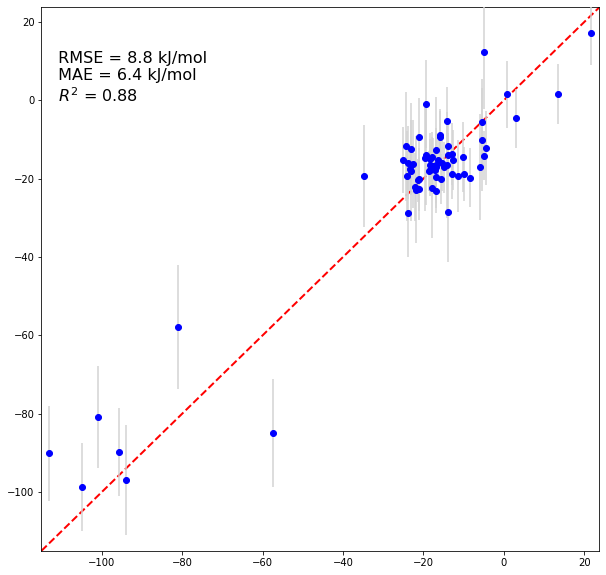

In [177]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
# fig = LOOCV_parity_plot(predictions_case_2_custom_cv, sigmas_case_2_custom_cv, 'LOOCV Parity Plot Case 2 Custom CV')
# fig.show()
LOOCV_parity_plot(predictions_case_2_custom_cv, sigmas_case_2_custom_cv, ax)
fig.show()

In [178]:
# Case 3 loocv, custom cv (case 2 + all dft data for hold-out)
errors_case_3_custom_cv = []
sigmas_case_3_custom_cv = []
predictions_case_3_custom_cv = []
first=True
for id_to_remove in exp_IDs_for_cases:
    indices_to_remove = df[(df['ID']==id_to_remove)&(df['source']=='expt')].index.tolist()
    # print(indices_to_remove)
    train_df = df.drop(index=indices_to_remove)
    x_train = train_df[fp_columns_fe].to_numpy()
    y_train = train_df['roe_kj/mol'].to_numpy()
    x_test = df_exp[df_exp['ID']==id_to_remove][fp_columns_fe].to_numpy()
    # print(x_test)
    y_test = df_exp[df_exp['ID']==id_to_remove]['roe_kj/mol'].to_numpy()
    
    model = GaussianProcessRegressor(**gpr_params)
    model.fit(x_train,y_train)
    prediction, sigma = model.predict(x_test, return_std=True)
    error = abs(y_test-prediction)
    if len(error) > 1:
        print(id_to_remove)
    errors_case_3_custom_cv.append(error)
    sigmas_case_3_custom_cv.append(sigma)
    predictions_case_3_custom_cv.append([y_test, prediction])
    # doing train metrics too for LOOCV
    predictions_train = model.predict(x_train, return_std=False)
    if first:
        predictions_case_3_custom_cv_train = np.stack([y_train, predictions_train],axis=1)
        first=False
    else:
        to_add = np.stack([y_train, predictions_train],axis=1)
        # print(to_add.shape, predictions_case_3_custom_cv_train.shape)
        predictions_case_3_custom_cv_train = np.concatenate([predictions_case_3_custom_cv_train, to_add], axis=0)
print(np.mean(errors_case_3_custom_cv))
predictions_case_3_custom_cv = np.array(predictions_case_3_custom_cv)

5.989844098199423


In [182]:
predictions_case_3_custom_cv = np.array(predictions_case_3_custom_cv)

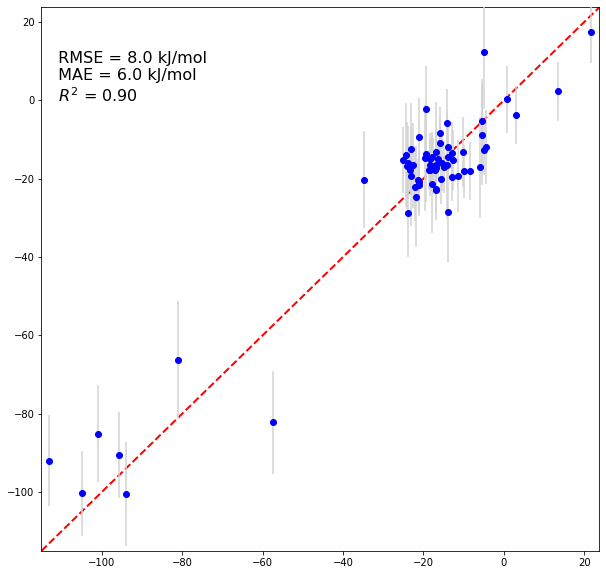

In [183]:
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(10,10)
# fig = LOOCV_parity_plot(predictions_case_3_custom_cv, sigmas_case_3_custom_cv, 'LOOCV Parity Plot Case 3 Custom CV')
LOOCV_parity_plot(predictions_case_3_custom_cv, sigmas_case_3_custom_cv, ax)
fig.show()

In [185]:
# exporting the results of the leave-one out results to add into the learning curve
# putting testing data in
output_df = pd.DataFrame(predictions_case_0_custom_cv.reshape(predictions_case_0_custom_cv.shape[0],predictions_case_0_custom_cv.shape[1]), columns=['actual', 'prediction'])
output_df['case'] = ['case 0']*output_df.shape[0]

to_add_df = pd.DataFrame(predictions_case_1_custom_cv.reshape(predictions_case_1_custom_cv.shape[0],predictions_case_1_custom_cv.shape[1]), columns=['actual', 'prediction'])
to_add_df['case'] = ['case 1']*to_add_df.shape[0]
output_df = pd.concat([output_df,to_add_df])

to_add_df = pd.DataFrame(predictions_case_2_custom_cv.reshape(predictions_case_2_custom_cv.shape[0],predictions_case_2_custom_cv.shape[1]), columns=['actual', 'prediction'])
to_add_df['case'] = ['case 2']*to_add_df.shape[0]
output_df = pd.concat([output_df,to_add_df])

to_add_df = pd.DataFrame(predictions_case_3_custom_cv.reshape(predictions_case_3_custom_cv.shape[0],predictions_case_3_custom_cv.shape[1]), columns=['actual', 'prediction'])
to_add_df['case'] = ['case 3']*to_add_df.shape[0]
output_df = pd.concat([output_df,to_add_df])

# putting training data in
output_df_train = pd.DataFrame(predictions_case_0_custom_cv_train.reshape(predictions_case_0_custom_cv_train.shape[0],predictions_case_0_custom_cv_train.shape[1]), columns=['actual', 'prediction'])
output_df_train['case'] = ['case 0']*output_df_train.shape[0]

to_add_df = pd.DataFrame(predictions_case_1_custom_cv_train.reshape(predictions_case_1_custom_cv_train.shape[0],predictions_case_1_custom_cv_train.shape[1]), columns=['actual', 'prediction'])
to_add_df['case'] = ['case 1']*to_add_df.shape[0]
output_df_train = pd.concat([output_df_train,to_add_df])

to_add_df = pd.DataFrame(predictions_case_2_custom_cv_train.reshape(predictions_case_2_custom_cv_train.shape[0],predictions_case_2_custom_cv_train.shape[1]), columns=['actual', 'prediction'])
to_add_df['case'] = ['case 2']*to_add_df.shape[0]
output_df_train = pd.concat([output_df_train,to_add_df])

to_add_df = pd.DataFrame(predictions_case_3_custom_cv_train.reshape(predictions_case_3_custom_cv_train.shape[0],predictions_case_3_custom_cv_train.shape[1]), columns=['actual', 'prediction'])
to_add_df['case'] = ['case 3']*to_add_df.shape[0]
output_df_train = pd.concat([output_df_train,to_add_df])


output_df['type'] = ['test']*output_df.shape[0]
output_df_train['type'] = ['train']*output_df_train.shape[0]
output_df = pd.concat([output_df, output_df_train])
output_df['RMSE (KJ/mol)'] = ((output_df['actual']-output_df['prediction'])**2)**(1/2)

In [186]:
print(output_df.shape)

(100738, 5)


In [187]:
output_df.to_csv('23-8-24_loocv_results_for_learning_curve.csv', index=False)

# Plotting parity plots for all algorithms for all cases in one nice figure

In [109]:
def LOOCV_parity_plot_all_data(all_data, all_stds, ax=False):
    if not ax:
        ax = plt.gca()
    min_x = all_data[:,0,:].min()
    max_x = all_data[:,0,:].max()
    min_y = all_data[:,1,:].min()
    max_y = all_data[:,1,:].max()
    bounds = (min(min_x - 2, min_y  - 2), max(max_x + 2, max_y + 2))
        
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    # putting parity line on
    ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)
    colors = ['green', 'orange', 'black', 'blue']
    # plotting each algorithms data one at a time
    labels = ['RF', 'SVM', 'BRF', 'GPR']
    for i in range(all_data.shape[2]):
        data = all_data[:,:,i]
        stds = all_stds[:,i]
        color = colors[i]
        
        ax.errorbar(data[:,0].flatten(), data[:,1].flatten(), 
                                  yerr=np.array(stds).flatten(), c=color, zorder=4, ecolor='lightgrey', fmt='o', label=labels[i])

        ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)

        # labeling axes
        # plt.title(title, fontsize=15, weight='bold')
        # plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
        # plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

    ## CALCULATE STATISTICS
    # I make sure that GPR results are put last so that the data is set to GPR algorithm for calculating statistics
    rmse = np.sqrt(mean_squared_error(data[:,0], data[:,1]))
    mae = mean_absolute_error(data[:,0], data[:,1])
    r2 = r2_score(data[:,0], data[:,1])
    text = f" RMSE = {rmse:0.1f} kJ/mol\n MAE = {mae:0.1f} kJ/mol\n $R^{2}$ = {r2:0.2f}"
    # ax.gca().text(0.05, 0.95, text_case_1,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.92, text,transform=ax.transAxes, fontsize=16, verticalalignment='top',) # weight="bold")
    return ax


In [110]:
# setting up data to be correct for above plotting function
dim_1 = predictions_case_0_custom_cv_rf.shape[0]
dim_2 = predictions_case_0_custom_cv_rf.shape[1]
# case 0
case_0_all_data = np.concatenate([
    predictions_case_0_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_0_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_0_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_0_custom_cv.reshape(dim_1, dim_2, 1)
], axis=2)

case_0_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array(sigmas_case_0_custom_cv).reshape(dim_1,1)], axis=1)

# LOOCV_parity_plot_all_data(case_0_all_data, case_0_all_stds)
# ax.show()

# case 1
case_1_all_data = np.concatenate([
    predictions_case_1_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv.reshape(dim_1, dim_2, 1)
], axis=2)

case_1_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array(sigmas_case_1_custom_cv).reshape(dim_1,1)], axis=1)

# case 2
case_2_all_data = np.concatenate([
    predictions_case_2_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv.reshape(dim_1, dim_2, 1)
], axis=2)

case_2_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array(sigmas_case_2_custom_cv).reshape(dim_1,1)], axis=1)
# case 3
case_3_all_data = np.concatenate([
    predictions_case_3_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv.reshape(dim_1, dim_2, 1)
], axis=2)

case_3_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array(sigmas_case_3_custom_cv).reshape(dim_1,1)], axis=1)

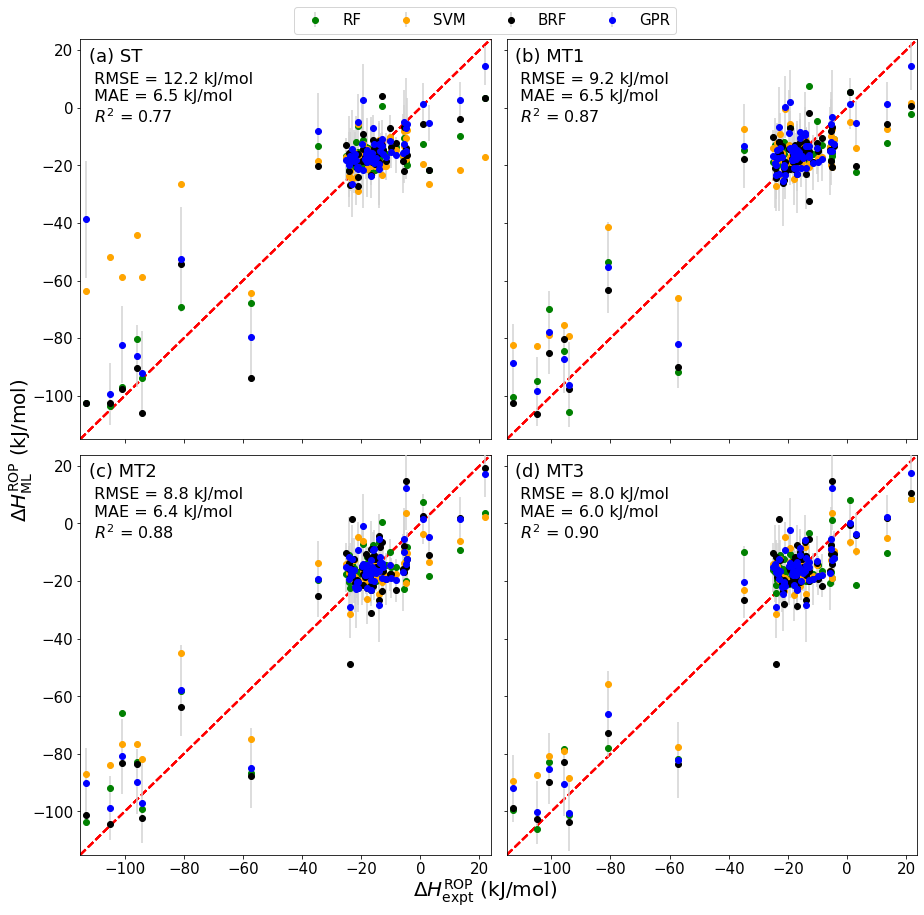

In [111]:
# creating nice plot of above work
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(15,15)

# Set common labels
fig.text(0.5, 0.09, '$\Delta H^{\mathrm{ROP}}_{\mathrm{expt}}$ (kJ/mol)', ha='center', va='center', size=20)
fig.text(0.07, 0.5, '$\Delta H^{\mathrm{ROP}}_{\mathrm{ML}}$ (kJ/mol)', ha='center', va='center', rotation='vertical', size=20)
# plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
# plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

ax1 = LOOCV_parity_plot_all_data(case_0_all_data, case_0_all_stds, ax=ax1)
text = "(a) ST"
ax1.text(0.02, 0.98, text,transform=ax1.transAxes, fontsize=18, verticalalignment='top') # weight="bold")
# ax1.set_title('Case 0')
# ax1 = fig1.add_sub_plot(111)
ax2 = LOOCV_parity_plot_all_data(case_1_all_data, case_1_all_stds, ax=ax2)
text = "(b) MT1"
ax2.text(0.02, 0.98, text,transform=ax2.transAxes, fontsize=18, verticalalignment='top') # weight="bold")
# ax2.set_title('Case 1')
ax3 = LOOCV_parity_plot_all_data(case_2_all_data, case_2_all_stds, ax=ax3)
text = "(c) MT2"
ax3.text(0.02, 0.98, text,transform=ax3.transAxes, fontsize=18, verticalalignment='top') #weight="bold")
# ax3.set_title('Case 2')
ax4 = LOOCV_parity_plot_all_data(case_3_all_data, case_3_all_stds, ax=ax4)
text = "(d) MT3"
ax4.text(0.02, 0.98, text,transform=ax4.transAxes, fontsize=18, verticalalignment='top') #weight="bold")
# ax4.set_title('Case 3')
# creating shared axes to reduce vacuum space between plots
# 1 and 2
ax1.get_shared_y_axes().join(ax1, ax2)
ax2.set_yticklabels([])
# 1 and 3
ax1.get_shared_x_axes().join(ax1, ax3)
ax1.set_xticklabels([])
# 3 and 4
ax3.get_shared_y_axes().join(ax3, ax4)
ax4.set_yticklabels([])
# 2 and 4
ax2.get_shared_x_axes().join(ax2, ax4)
ax2.set_xticklabels([])
# adjusting white space
plt.subplots_adjust(wspace=0.04, hspace=0.04)
# adjusting tick font size
ax1.yaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.xaxis.set_tick_params(labelsize=15)
ax4.xaxis.set_tick_params(labelsize=15)
# add legend
handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=15,borderaxespad=0., bbox_to_anchor=(0.5, 0.91))
fig.show()
fig.savefig('../../paper_writing/first_enthalpy_ml_paper/figures/parity_plots_with_all_algorithms_added.pdf')

In [1]:
# plotting only MT3 for TOC
fig,ax = plt.subplots(1)
fig.set_size_inches(15,15)
ax = LOOCV_parity_plot_all_data(case_3_all_data, case_3_all_stds, ax=ax)

NameError: name 'plt' is not defined

# Replotting so that the analysis is by algorithm rather than by learning task. Need to make colors better

In [114]:
import matplotlib as mpl
print(mpl.rcParams['axes.prop_cycle'])

cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


In [133]:
def LOOCV_parity_plot_all_data_by_algo(all_data, all_stds, ax=False):
    if not ax:
        ax = plt.gca()
    min_x = all_data[:,0,:].min()
    max_x = all_data[:,0,:].max()
    min_y = all_data[:,1,:].min()
    max_y = all_data[:,1,:].max()
    bounds = (min(min_x - 2, min_y  - 2), max(max_x + 2, max_y + 2))
        
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    # putting parity line on
    ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)
    colors = ['g', 'm', 'k', 'b']
    symbols = ['^', 'o', '*', 'P']
    # plotting each algorithms data one at a time
    labels = ['ST', 'MT1', 'MT2', 'MT3']
    for i in range(all_data.shape[2]):
        data = all_data[:,:,i]
        stds = all_stds[:,i]
        color = colors[i]
        symbol = symbols[i]
        
        ax.errorbar(data[:,0].flatten(), data[:,1].flatten(), 
                                  yerr=np.array(stds).flatten(), c=color, zorder=4, ecolor='lightgrey', fmt='o', label=labels[i], marker=symbol)

        ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)

        # labeling axes
        # plt.title(title, fontsize=15, weight='bold')
        # plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
        # plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

    ## CALCULATE STATISTICS
    # I make sure that MT3 results are put last so that the data is set to GPR algorithm for calculating statistics
    rmse = np.sqrt(mean_squared_error(data[:,0], data[:,1]))
    mae = mean_absolute_error(data[:,0], data[:,1])
    r2 = r2_score(data[:,0], data[:,1])
    text = f" MT3 RMSE = {rmse:0.1f} kJ/mol\n MT3 MAE = {mae:0.1f} kJ/mol\n MT3 $R^{2}$ = {r2:0.2f}"
    # ax.gca().text(0.05, 0.95, text_case_1,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.92, text,transform=ax.transAxes, fontsize=16, verticalalignment='top',) # weight="bold")
    return ax


In [134]:
# setting up data to be correct for above plotting function
dim_1 = predictions_case_0_custom_cv_rf.shape[0]
dim_2 = predictions_case_0_custom_cv_rf.shape[1]

# rf
rf_all_data = np.concatenate([
    predictions_case_0_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv_rf.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv_rf.reshape(dim_1, dim_2, 1)
], axis=2)

rf_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1)], axis=1)

# svr
svr_all_data = np.concatenate([
    predictions_case_0_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv_svr.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv_svr.reshape(dim_1, dim_2, 1)
], axis=2)

svr_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1)], axis=1)
# xgb
xgb_all_data = np.concatenate([
    predictions_case_0_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv_xgb.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv_xgb.reshape(dim_1, dim_2, 1)
], axis=2)

xgb_all_stds = np.concatenate([np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1),
                                 np.array([0 for x in range(dim_1)]).reshape(dim_1,1)], axis=1)
# gpr
gpr_all_data = np.concatenate([
    predictions_case_0_custom_cv.reshape(dim_1, dim_2, 1),
    predictions_case_1_custom_cv.reshape(dim_1, dim_2, 1),
    predictions_case_2_custom_cv.reshape(dim_1, dim_2, 1),
    predictions_case_3_custom_cv.reshape(dim_1, dim_2, 1)
], axis=2)

gpr_all_stds = np.concatenate([np.array(sigmas_case_0_custom_cv).reshape(dim_1,1),
                                 np.array(sigmas_case_1_custom_cv).reshape(dim_1,1),
                                 np.array(sigmas_case_2_custom_cv).reshape(dim_1,1),
                                 np.array(sigmas_case_3_custom_cv).reshape(dim_1,1)], axis=1)

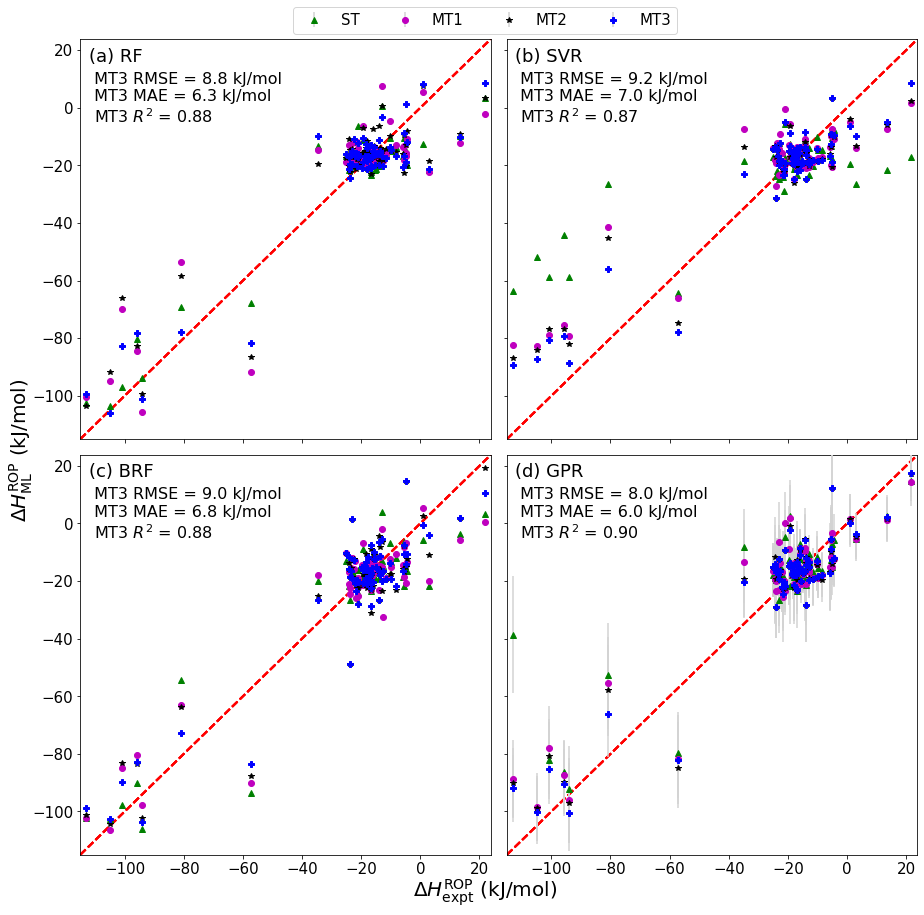

In [135]:
# creating nice plot of above work
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(15,15)

# Set common labels
fig.text(0.5, 0.09, '$\Delta H^{\mathrm{ROP}}_{\mathrm{expt}}$ (kJ/mol)', ha='center', va='center', size=20)
fig.text(0.07, 0.5, '$\Delta H^{\mathrm{ROP}}_{\mathrm{ML}}$ (kJ/mol)', ha='center', va='center', rotation='vertical', size=20)
# plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
# plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

ax1 = LOOCV_parity_plot_all_data_by_algo(rf_all_data, rf_all_stds, ax=ax1)
text = "(a) RF"
ax1.text(0.02, 0.98, text,transform=ax1.transAxes, fontsize=18, verticalalignment='top') # weight="bold")
# ax1.set_title('Case 0')
# ax1 = fig1.add_sub_plot(111)
ax2 = LOOCV_parity_plot_all_data_by_algo(svr_all_data, svr_all_stds, ax=ax2)
text = "(b) SVR"
ax2.text(0.02, 0.98, text,transform=ax2.transAxes, fontsize=18, verticalalignment='top') # weight="bold")
# ax2.set_title('Case 1')
ax3 = LOOCV_parity_plot_all_data_by_algo(xgb_all_data, xgb_all_stds, ax=ax3)
text = "(c) BRF"
ax3.text(0.02, 0.98, text,transform=ax3.transAxes, fontsize=18, verticalalignment='top') #weight="bold")
# ax3.set_title('Case 2')
ax4 = LOOCV_parity_plot_all_data_by_algo(gpr_all_data, gpr_all_stds, ax=ax4)
text = "(d) GPR"
ax4.text(0.02, 0.98, text,transform=ax4.transAxes, fontsize=18, verticalalignment='top') #weight="bold")
# ax4.set_title('Case 3')
# creating shared axes to reduce vacuum space between plots
# 1 and 2
ax1.get_shared_y_axes().join(ax1, ax2)
ax2.set_yticklabels([])
# 1 and 3
ax1.get_shared_x_axes().join(ax1, ax3)
ax1.set_xticklabels([])
# 3 and 4
ax3.get_shared_y_axes().join(ax3, ax4)
ax4.set_yticklabels([])
# 2 and 4
ax2.get_shared_x_axes().join(ax2, ax4)
ax2.set_xticklabels([])
# adjusting white space
plt.subplots_adjust(wspace=0.04, hspace=0.04)
# adjusting tick font size
ax1.yaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.xaxis.set_tick_params(labelsize=15)
ax4.xaxis.set_tick_params(labelsize=15)
# add legend
handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=15,borderaxespad=0., bbox_to_anchor=(0.5, 0.91))
fig.show()
fig.savefig('../../paper_writing/first_enthalpy_ml_paper/figures/23-8-24-parity_plots_with_all_algorithms_sorted_by_algo.pdf')